# Combined model with BOSS

In [2]:
import pandas as pd
import numpy as np

from tsfresh.feature_extraction import extract_features, EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import matplotlib.pyplot as plt

from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_sample_weight
from tsfresh.feature_selection import select_features
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate

from pyts.transformation import BOSS

from catboost import CatBoostClassifier

from spark.utils import channel_wise_boss, boss_transform_data
from spark.preprocessor import preprocessor

%load_ext autoreload
%autoreload 2

In [3]:
raw_data_prep_dir = '../raw_data/pads-parkinsons-disease-smartwatch-dataset-1.0.0/preprocessed/'

In [4]:
file_list = pd.read_csv(raw_data_prep_dir  + "file_list.csv")
file_list

,resource_type,id,study_id,condition,disease_comment,age_at_diagnosis,age,height,weight,gender,handedness,appearance_in_kinship,appearance_in_first_grade_kinship,effect_of_alcohol_on_tremor,label
0,patient,1,PADS,Healthy,-,56,56,173,78,male,right,True,True,Unknown,0
1,patient,2,PADS,Other Movement Disorders,Left-Sided resting tremor and hypokinesia with...,69,81,193,104,male,right,False,NaN,No effect,2
2,patient,3,PADS,Healthy,-,45,45,170,78,female,right,False,NaN,Unknown,0
3,patient,4,PADS,Parkinson's,IPS akinetic-rigid type,63,67,161,90,female,right,False,NaN,No effect,1
4,patient,5,PADS,Parkinson's,IPS tremordominant type,65,75,172,86,male,left,False,NaN,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464,patient,465,PADS,Parkinson's,IPS mixed type,62,65,175,80,male,right,True,False,No effect,1
465,patient,466,PADS,Healthy,-,84,84,172,74,female,right,True,True,No effect,0
466,patient,467,PADS,Parkinson's,"Essential Tremor, starting IPS tremordominant ...",55,57,190,100,male,right,False,NaN,Improvement,1
467,patient,468,PADS,Parkinson's,IPS mixed type,73,76,198,118,male,right,False,NaN,No effect,1


In [5]:
X_train_q, X_test_q, y_train_q, y_test_q = preprocessor("~/code/marzecovaa/spark/processed_data/merged_dfq.csv")

✅ Transformer saved at: ./model_registry/transformer_20250909-160134.joblib


In [6]:
X_train_q.shape

(375, 38)

In [7]:
time_data = []
y = []
X_to_split = []
for idx, subject_idx in enumerate(file_list['id']):
    file_name = raw_data_prep_dir + f'movement/{subject_idx:03d}_ml.bin'
    time_idx_data = np.fromfile(file_name, dtype=np.float32).reshape((-1, 976))
    time_data.append(time_idx_data)
    y_idx = file_list[file_list['id']==subject_idx].label.values
    X_id = idx
    y.append(y_idx)
    X_to_split.append(X_id)

X_to_split = np.array(X_to_split)
y = np.array(y).flatten()
time_data = np.array(time_data)
print(time_data.shape)
time_data.shape[0]
range(time_data.shape[0])

(469, 132, 976)


range(0, 469)

In [8]:
#train test split
X_train_idx, X_test_idx, y_train, y_test = train_test_split(X_to_split, y, test_size=0.20, random_state=42, stratify = y)
X_train = time_data[X_train_idx]
X_test = time_data[X_test_idx]
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))
X_train.shape

375 94
375 94


(375, 132, 976)

In [9]:
boss = channel_wise_boss(X_train, n_bins = 4, window_step = 2, window_size = 10, word_size = 6) #Save this to transform

BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(window_step=2, word_size=6)
BOSS(windo

KeyboardInterrupt: 

In [ ]:
X_train_boss = boss_transform_data(boss,X_train)

1


In [ ]:
X_test_boss = boss_transform_data(boss,X_test)

1


In [ ]:
pd.DataFrame(X_train_boss)
np.max(X_train_boss, axis = 1)

array([66, 50, 69, 54, 58, 47, 63, 86, 68, 89, 65, 71, 75, 62, 60, 65, 76,
       59, 61, 68, 67, 43, 69, 54, 60, 69, 69, 67, 52, 71, 53, 67, 66, 77,
       44, 92, 59, 65, 71, 67, 81, 60, 63, 66, 51, 59, 42, 79, 92, 63, 41,
       58, 55, 71, 60, 88, 47, 66, 65, 61, 55, 74, 53, 82, 60, 68, 50, 44,
       55, 59, 70, 67, 51, 81, 84, 52, 60, 60, 61, 64, 64, 61, 55, 65, 50,
       54, 70, 73, 54, 76, 73, 55, 66, 54, 70, 45, 72, 62, 53, 55, 51, 78,
       52, 50, 58, 48, 63, 53, 88, 49, 56, 64, 70, 60, 64, 76, 73, 69, 42,
       65, 59, 59, 62, 61, 78, 56, 56, 48, 58, 59, 64, 73, 52, 47, 44, 70,
       62, 80, 68, 60, 64, 76, 72, 58, 66, 73, 72, 64, 47, 68, 58, 78, 58,
       60, 69, 58, 75, 79, 63, 51, 61, 54, 51, 45, 56, 60, 72, 68, 50, 75,
       84, 61, 69, 49, 58, 68, 51, 72, 74, 52, 51, 80, 54, 67, 73, 59, 57,
       72, 50, 58, 59, 61, 71, 66, 72, 56, 59, 77, 55, 62, 77, 47, 47, 71,
       65, 54, 69, 64, 53, 53, 63, 71, 54, 73, 53, 53, 56, 68, 61, 47, 58,
       46, 59, 64, 68, 76

In [68]:
pca = PCA(n_components = 125, random_state = 23)

In [ ]:
X_pca_train = pca.fit_transform(X= X_train_boss)
X_pca_test = pca.transform(X=X_test_boss)
X_pca_test.shape

(94, 125)

In [17]:
cat_model_pca = CatBoostClassifier(iterations = 2000,
                                    learning_rate = 0.05,
                                    depth = 7)

In [18]:
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

cat_model_pca.fit(X_pca_train, y_train,
                  eval_set = (X_pca_test, y_test),
                  use_best_model = True,
                  sample_weight=sample_weights)

0:	learn: 1.0875777	test: 1.0983883	best: 1.0983883 (0)	total: 71.1ms	remaining: 2m 22s
1:	learn: 1.0732813	test: 1.0949522	best: 1.0949522 (1)	total: 82.4ms	remaining: 1m 22s
2:	learn: 1.0638953	test: 1.0925224	best: 1.0925224 (2)	total: 94.6ms	remaining: 1m 2s
3:	learn: 1.0510655	test: 1.0913855	best: 1.0913855 (3)	total: 107ms	remaining: 53.3s
4:	learn: 1.0413787	test: 1.0923438	best: 1.0913855 (3)	total: 119ms	remaining: 47.4s
5:	learn: 1.0313167	test: 1.0899761	best: 1.0899761 (5)	total: 131ms	remaining: 43.4s
6:	learn: 1.0216031	test: 1.0902775	best: 1.0899761 (5)	total: 142ms	remaining: 40.6s
7:	learn: 1.0118762	test: 1.0904842	best: 1.0899761 (5)	total: 154ms	remaining: 38.4s
8:	learn: 1.0007653	test: 1.0886682	best: 1.0886682 (8)	total: 166ms	remaining: 36.7s
9:	learn: 0.9906177	test: 1.0879884	best: 1.0879884 (9)	total: 177ms	remaining: 35.2s
10:	learn: 0.9808052	test: 1.0858131	best: 1.0858131 (10)	total: 188ms	remaining: 34s
11:	learn: 0.9696123	test: 1.0847670	best: 1.0847

In [19]:
y_pred_cat = cat_model_pca.predict(X_pca_test)

In [20]:
cat_accuracy = balanced_accuracy_score(y_test, y_pred_cat)
f'cat_accuracy: {cat_accuracy}'

'cat_accuracy: 0.494433465085639'

In [21]:
sv_model_pca = SVC(kernel = 'rbf', class_weight = 'balanced', C = 1)
sv_model_pca.fit(X_pca_train, y_train)

,C,1
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,'balanced'
,verbose,False


In [22]:
y_pred_pca_sv = sv_model_pca.predict(X_pca_test)
balanced_accuracy_score(y_test, y_pred_pca_sv)

0.7127470355731225

In [33]:
X_combined_train = np.concatenate((X_train_boss, X_train_q), axis = 1)
X_combined_test = np.concatenate((X_test_boss, X_test_q), axis = 1)
X_combined_train.shape

(375, 378482)

In [64]:
pca_combined = PCA(n_components = 125,random_state=23)
X_pca_combo_train = pca_combined.fit_transform(X= X_combined_train)
X_pca_combo_test = pca_combined.transform(X=X_combined_test)


In [65]:
sv_model_pca_combined = SVC(kernel = 'rbf', class_weight = 'balanced', C = 1)
sv_model_pca_combined.fit(X_pca_combo_train, y_train)

,C,1
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,'balanced'
,verbose,False


In [66]:
y_pred_pca_combo = sv_model_pca_combined.predict(X_pca_combo_test)

In [67]:
y_pred_pca_combo = sv_model_pca_combined.predict(X_pca_combo_test)
balanced_accuracy_score(y_test, y_pred_pca_combo)

0.7130270092226613

In [ ]:
xgb = XGBClassifier()

50
75
100
125
150
175
200
250
50
75
100
125
150
175
200
250
50
75
100
125
150
175
200
250
50
75
100
125
150
175
200
250
50
75
100
125
150
175
200
250
50
75
100
125
150
175
200
250
50
75
100
125
150
175
200
250
50
75
100
125
150
175
200
250
50
75
100
125
150
175
200
250


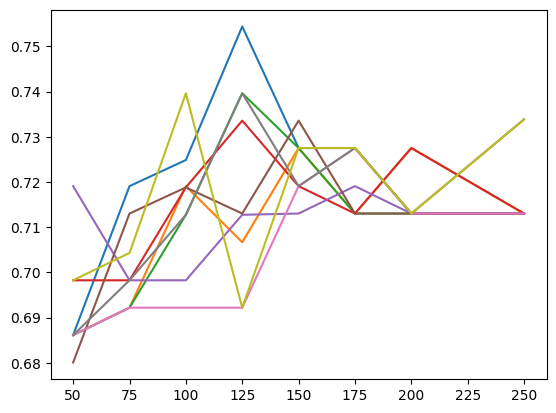

In [54]:
n_comps = [50, 75, 100, 125, 150, 175, 200, 250]

random_state = [1, 3, 7, 9, 13, 23, 33, 99, 123]
for r in random_state:
    accuracy = []
    for n in n_comps:
        print(n)
        pca = PCA(n_components=n, random_state = r)
        X_pca_combo_train = pca.fit_transform(X= X_combined_train)
        X_pca_combo_test = pca.transform(X=X_combined_test)
        sv_model_pca_combined = SVC(kernel = 'rbf', class_weight = 'balanced', C = 1)
        sv_model_pca_combined.fit(X_pca_combo_train, y_train)
        y_pred_pca_combo = sv_model_pca_combined.predict(X_pca_combo_test)
        accuracy.append(balanced_accuracy_score(y_test, y_pred_pca_combo))
    plt.plot(n_comps, accuracy)

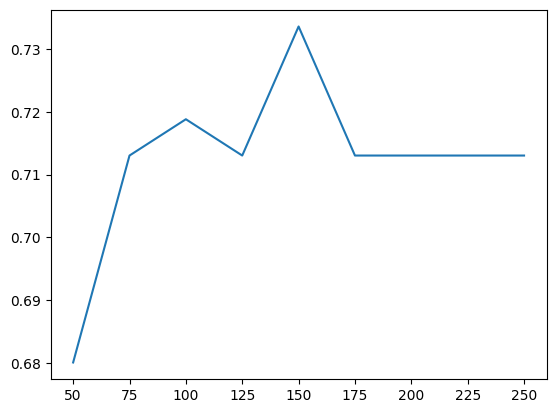

In [48]:
plt.plot(n_comps, accuracy)
